# Race Dashboard



This document describes the requirements and design decisions we will adopt for the Race Dashboard for the Sanofi Asset Efficiency challenge.  This document is intended to provide a detailed explanation of what is to be included on the dashboard, required data sources, and assumptions being made in the design.  It will also show the steps for getting the data into the necessary format.

## Scope/objective

The objective is to be able to display the documented metrics and categories as best suited on a Dashboard presentation for Sanofi staff to be able to access.


## Metrics / categories
The metrics have been mapped into sectors to mimic different sectors of a race track.  The metrics are:
 
 
 
•     Race = 8 Laps = 8 Months   
•     Lap = Monthly Progress   
<br>
<br>

•     **Sector 1 = OEE Improvement   
•     Sector 2 = OEE Variability Improvement   
•     Sector 3 = Stoppage Reduction   
•     Sector 4 = Changeover Improvement**   
• _Sector 5 = Most effective OEE application   
• Sector 6 = Best Innovation   
• Sector 7 = Most consistent OEE improvement progress   
• Sector 8 = Collaboration   
• Sector 9 = Team Spirit_

 
 


| Change log |
|:----------:|    


| Date | Initials | Comments |
|------|:---------|:---------|
| 2021-06-23 | MC | in leaderboard, replace NaN values in laptime calc with the max laptime for that lap
| 2021-06-23 | MC | use race review dates for grouping data, rather than calendar months
| 2021-06-24 |JB | missing OEE_Diff figures should default to 'OEE %' - OEE start point, not just 'OEE %' value
| 2021-06-24 |JB | for sector one, multiply sum of OEE_Diff by -1.  (was doing this in Tableau calcs but too late for lap_time calc).
|2021-06-25 | MC | in leaderboard, change prev_race_time calc to include all but last 2 cols, to handle new race cols as they arrive
|2021-06-28 | MC | correct dates in nominations spreadsheet, and merge on 1 row with a date within the review period
|2021-06-29 | MC | corrected nominations spreadsheet for Lisieux IWK - should be TR200 Packaging
|2021-06-30 | MC | populate missing OEE % values before calculating rolling_std using the OEE % column
|2021-06-30 | MC | remove start_changeover_calc merge as it's not being used any more, and was dropping rows
|2021-07-06 | MC | populate missing OEE % values with OEE from previous week for that site.
|2021-07-12 | MC | import nominations for sectors 10 and 11
|2021-08-21 | MC | create a Plant Line column and pass into df_weekly_with_calcs for dash presentation
|2021-08-21 | MC | add sector 12 for Better Together.  Apply 25% weighting

In [216]:
import pandas as pd
import numpy as np
import datetime


# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# display options
# pd.options.display.float_format = "{:.2f}".format


## Read file and cleanse

- OEE.xlsx should contain the OEE latest data from QS by week   
- QSDashboard.xlsx has a list of plants/sites taking part, with original target OEE  
- UnplannedTechLoss.xlxs should contain the latest data from QS (my unplanned chart by line/week)   
- changeover.xlsx should contain the changeover information in QlikSense

#### Cleaning required:   
- OEE % needs converting to numeric, coerce the nulls to nan values
- I think W53-2020 data is bobbings - causes dup indexes for date 2021-01-10 and don't need 2020 data anyway...so dropping it

In [217]:
# this needs a settings.cfg file in the same directory

import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1


dir_local = ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_alarms = ConfigSectionMap("SectionOne")['alarms']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_alarms is %s" % (dir_alarms))
print ("dir_local is %s" % (dir_local))

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/
dir_alarms is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/Alarms_data/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [218]:
def read_excel_file(dir, folder, filename):
    path = os.path.join(dir, folder, filename)
    temp_df = pd.read_excel(path)
    return temp_df

folder = 'Race Dashboard data'

file = ('OEE.xlsx')
df_weekly = read_excel_file(dir_sanofi_share, folder, file)

file = ('QSDashboard.xlsx')
df_dash = read_excel_file(dir_sanofi_share, folder, file)

file = ('Unplanned_tech_loss.xlsx')
df_techloss = read_excel_file(dir_sanofi_share, folder, file)

file = ('changeover.xlsx')
df_changeover = read_excel_file(dir_sanofi_share, folder, file)


df_weekly = df_weekly.loc[df_weekly['Week'].str.contains('2021')]
df_techloss = df_techloss.loc[df_techloss['Week'].str.contains('2021')]
df_weekly['OEE %'] = pd.to_numeric(df_weekly['OEE %'], errors='coerce')
df_techloss.rename(columns={'Unplanned losses - %OEE':'Unplanned_tech_loss'}, inplace=True)
df_techloss['Unplanned_tech_loss'] = pd.to_numeric(df_techloss['Unplanned_tech_loss'], errors='coerce')
df_changeover.rename(columns={'Change over losses - %OEE':'Changeover'}, inplace=True)
df_changeover['Changeover'] = pd.to_numeric(df_changeover['Changeover'], errors='coerce')
# don't use their progress figure as it's a static val
# df_dash.rename(columns={'⇗ OEE% progress':'OEE% progress'}, inplace=True)

In [219]:
# identify any rows without a start OEE and fix them manually in the following cell (cen't be bothered to automate!)
index_to_fix = df_dash[~df_dash['OEE  Start point'].apply(np.isreal)].index

In [220]:
# df_dash.loc[index_to_fix] = 0.585
df_dash['OEE  Start point'].loc[index_to_fix] = 0.585
df_dash

C:\Users\mark_\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Plant,Line,OEE Start point,⇗ OEE% progress,OEE% _last_4_w,Capa uti last 4w,On_track_OEE,Way to go ⇗,OEE% Target (2022),CO_4w_ptOEE%,Unpl_tech_loss_4w,Form,Process
0,Tours,TRS - L18 Packaging Line,0.377683,0.143886,52.2 % +/-5 % ▲,42.728321,☀,0.025431,0.547,15.7 %▲,15.3 %▲,TABS_CAPSULES,PACKAGING
1,Tours,TRS - L25 Packaging Line,0.351564,0.054473,40.6 % +/-17 % ▲,36.544663,☀,0.071963,0.478,25.5 %▼,12.8 %▼,TABS_CAPSULES,PACKAGING
2,SUZANO,SUZ - LINE 01 - UHLMANN 1880,0.414921,-0.029883,38.5 % +/-9 % ▼,58.462712,☂,0.134963,0.520,3.1 %▼,25.7 %▲,TABS_CAPSULES,PACKAGING
3,SUZANO,SUZ - MEDISEAL PURAN,0.577761,-0.067184,51.1 % +/-12 % ▼,79.893207,☂,0.096423,0.607,6.1 %▼,22.8 %▲,TABS_CAPSULES,PACKAGING
4,SCOPPITO,SCO - GAMMA1,0.418683,0.064406,48.3 % +/-14 % ▼,24.201683,☁,0.166911,0.650,22.3 %▲,20.0 %▲,TABS_CAPSULES,PACKAGING
5,SCOPPITO,SCO - IMA C80/2,0.451031,0.203036,65.4 % +/-14 % ▲,39.158745,☀,-0.004067,0.650,12.4 %▼,12.4 %▼,TABS_CAPSULES,PACKAGING
6,Maisons-Alfort,MAF - C2 Packaging Line,0.399597,-0.008518,39.1 % +/-9 % ▲,37.827592,☁,0.078921,0.470,4.1 %▼,43.7 %▼,LIQUID,PACKAGING
7,Maisons-Alfort,MAF - C9 Packaging Line,0.419899,0.120523,54.0 % +/-8 % ▼,38.294834,☀,-0.010422,0.530,4.9 %▲,27.5 %▼,LIQUID,PACKAGING
8,Luleburgaz,LLB - Bosch-2 Packaging (SOLD),0.585,-,58.5 % +/-19 % ▼,79.993208,☀,-0.024607,0.560,5.9 %▲,13.5 %▲,TABS_CAPSULES,PACKAGING
9,Luleburgaz,LLB - IMA-2 Packaging (SOLD),0.466862,-0.033337,43.4 % +/-22 % ▼,63.933424,☂,0.216475,0.650,7.7 %▼,18.2 %▼,TABS_CAPSULES,PACKAGING


In [221]:
# we're ignoring data from before 2021-04-01
start_date = '2021-04-01'

# this is needed to prevent including additional values in the race time.
# 	Review_Date
# 0	2021-04-15
# 1	2021-05-13
# 2	2021-06-10
# 3	2021-07-08
# 4	2021-08-19
# 5	2021-09-16
# 6	2021-10-14
# 7	2021-11-18

review_date = '2021-09-16'


create a datetime from the week number

In [222]:
df_weekly['WeekOfYear'] = pd.to_numeric(df_weekly['Week'].str[1:3])
df_weekly['Year'] = pd.to_numeric(df_weekly['Week'].str[4:])
dates = df_weekly.Year*100+df_weekly.WeekOfYear
df_weekly['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
# df_weekly.drop(columns=['Year','WeekOfYear'], inplace=True)
df_weekly.head()

,Week,Line,OEE %,WeekOfYear,Year,Date
11,W01-2021,FRA - M18 Filling,NaN,1,2021,2021-01-10
12,W01-2021,FRA - M21 Filling,0.229414,1,2021,2021-01-10
13,W01-2021,FRA - M22 Filling,0.000012,1,2021,2021-01-10
14,W01-2021,LSX - SUPPO Packaging Line,0.254828,1,2021,2021-01-10
15,W01-2021,LSX - TR200 Packaging Line,0.271082,1,2021,2021-01-10


In [223]:
# set start_oee_date to the min date in df_weekly
start_oee_date = df_weekly.Date.min()
# up to before April
end_oee_date = '2021-03-31'

df_dates=df_weekly[(df_weekly.Date >= start_oee_date) & (df_weekly.Date <= end_oee_date) ]
df_dates = df_dates.groupby(['Line'])[['OEE %']].mean().reset_index()
df_dates.rename(columns={'OEE %':'McL_Start_OEE'}, inplace=True)
df_dash = df_dash.merge(df_dates, on='Line', how='outer')



In [224]:
filename = 'QSDashboard_McL.xlsx'
df_dash.to_excel(os.path.join(dir_local, folder, filename))

In [225]:
#merge the 2 dataframes to get the start OEE
df_weekly = df_weekly.merge(df_dash[['Plant','Line', 'OEE  Start point','OEE% Target (2022)', 'McL_Start_OEE']],on='Line')

In [226]:
df_weekly = df_weekly.merge(df_techloss[['Line', 'Week', 'Unplanned_tech_loss']],on=['Line','Week'])

In [227]:
df_weekly = df_weekly.merge(df_changeover[['Line','Week','Changeover']])

In [228]:
df_weekly[['Date','Line','OEE %']][df_weekly.Line.str.contains('AL5')]

,Date,Line,OEE %
410,2021-04-04,FRA - AL5 Packaging 1,NaN
411,2021-04-11,FRA - AL5 Packaging 1,NaN
412,2021-04-18,FRA - AL5 Packaging 1,0.449745
413,2021-04-25,FRA - AL5 Packaging 1,0.642652
414,2021-05-02,FRA - AL5 Packaging 1,0.505804
415,2021-05-09,FRA - AL5 Packaging 1,0.443611
416,2021-05-16,FRA - AL5 Packaging 1,0.507565
417,2021-05-23,FRA - AL5 Packaging 1,NaN
418,2021-05-30,FRA - AL5 Packaging 1,NaN
419,2021-06-06,FRA - AL5 Packaging 1,0.000000


In [229]:
df_weekly.groupby(['Line','OEE  Start point']).mean()

,,OEE %,WeekOfYear,Year,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover
Line,OEE Start point,,,,,,,
FRA - AL5 Packaging 1,0.479693,0.439652,25,2021,0.500,NaN,0.272839,0.075426
FRA - AL6,0.332657,0.386629,25,2021,0.485,NaN,0.345962,0.066647
FRA - M18 Filling,0.443522,0.435567,19,2021,0.650,0.454063,0.198699,0.241436
FRA - M21 Filling,0.599671,0.565094,19,2021,0.650,0.577681,0.124964,0.201441
FRA - M22 Filling,0.530068,0.522255,19,2021,0.650,0.468289,0.193500,0.184790
LLB - Bosch-2 Packaging (SOLD),0.585000,0.566542,36,2021,0.560,NaN,0.144708,0.058553
LLB - IMA-2 Packaging (SOLD),0.466862,0.459322,27,2021,0.650,NaN,0.279076,0.109618
LSX - SUPPO Packaging Line,0.353021,0.383808,19,2021,0.530,0.297096,0.206813,0.082742
LSX - TR200 Packaging Line,0.483505,0.524567,19,2021,0.650,0.462551,0.205316,0.162117


#### Start Changeover

*not sure this is needed if we are using changeover_diff, which will naturally reward increases / decreases in changeover??*

Start changeover value isn't provided, so going to calc our own start point using the average changeover for each site in 2021 up to April 2021.  This needs to be done before we drop the early 2021 rows.

This is then merged into the df_weekly dataframe as a loose join.

In [230]:
# start_changeover_calc = df_weekly[['Plant','Line','Changeover']][df_weekly['Date'] < '2021-04-30'].groupby(['Plant','Line']).mean().reset_index()
# start_changeover_calc.rename(columns={'Changeover':'start_changeover'}, inplace=True)
# df_weekly = df_weekly.merge(start_changeover_calc[['Line','start_changeover']])

#### Dates for the Asset Challenge

Start Date is going to be fixed as 2021-04-01. Remove all the rows from df_weekly before this date

Review Date will move and act as a cutoff for each Race meeting

In [231]:
df_weekly = df_weekly[df_weekly['Date'] > start_date].sort_values('Date')



### PCT_CHANGE
Using pct_change python function with periods=4, giving a 4 week (4 previous rows) rolling pct_change figure
- I believe we are doing this rolling average calculation within Tableau at the moment, so this isn't being used here

- Not sure whether this is required any more - removing for all categories (2021-06-30)

In [232]:
# df_weekly.sort_values(['Line','Date'], inplace = True)
# df_weekly['OEE_pct_chg'] = (df_weekly.groupby('Line')['OEE %']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly['techloss_pct_chg'] = (df_weekly.groupby('Line')['Unplanned_tech_loss']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly['Changeover_pct_chg'] = (df_weekly.groupby('Line')['Changeover']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly.head()

#### Populate missing OEE %
2021-06-07 - change of plan! Populating with min OEE value does not work when some Lines record 0% OEE.  Missing values can be just delayed data collection which sorts itself later.  So, until proper data arrives:

- Use the previous week's value (ffill) for that Line.  This will still leave NaN if they existed in the first row(s).  
- populate the remaining NaN with 'OEE  start point'
- ~~Find the weekly min/max OEE % from any site~~   
- ~~Merge those columns into df_weekly~~   
- ~~fill any NaN with the min OEE we calc'd for that week~~    


In [233]:
# df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['OEE %'].abs())
#        .groupby(pd.Grouper(key='Date',freq='W'))['OEE %'].agg([('Min' , 'min'), ('Max', 'max')])
#        .add_prefix('Week'))
# df_weekly_minmax.reset_index(inplace=True)
# df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekMin','WeekMax']])
# df_weekly['OEE %'].fillna(df_weekly.WeekMin, inplace=True)
# df_weekly.drop(columns=['WeekMin','WeekMax'], inplace=True)
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].ffill()
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].fillna(df_weekly['OEE  Start point'])
# df_weekly[df_weekly['OEE %'].isna()]
df_weekly[df_weekly.Line.str.contains('AL5')]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover
410,W13-2021,FRA - AL5 Packaging 1,0.479693,13,2021,2021-04-04,Frankfurt,0.479693,0.5,NaN,NaN,NaN
411,W14-2021,FRA - AL5 Packaging 1,0.479693,14,2021,2021-04-11,Frankfurt,0.479693,0.5,NaN,NaN,NaN
412,W15-2021,FRA - AL5 Packaging 1,0.449745,15,2021,2021-04-18,Frankfurt,0.479693,0.5,NaN,0.314964,0.087039
413,W16-2021,FRA - AL5 Packaging 1,0.642652,16,2021,2021-04-25,Frankfurt,0.479693,0.5,NaN,0.135051,0.122727
414,W17-2021,FRA - AL5 Packaging 1,0.505804,17,2021,2021-05-02,Frankfurt,0.479693,0.5,NaN,0.280638,0.063261
415,W18-2021,FRA - AL5 Packaging 1,0.443611,18,2021,2021-05-09,Frankfurt,0.479693,0.5,NaN,0.302882,0.089293
416,W19-2021,FRA - AL5 Packaging 1,0.507565,19,2021,2021-05-16,Frankfurt,0.479693,0.5,NaN,0.230673,0.060573
417,W20-2021,FRA - AL5 Packaging 1,0.507565,20,2021,2021-05-23,Frankfurt,0.479693,0.5,NaN,NaN,NaN
418,W21-2021,FRA - AL5 Packaging 1,0.507565,21,2021,2021-05-30,Frankfurt,0.479693,0.5,NaN,NaN,NaN
419,W22-2021,FRA - AL5 Packaging 1,0.000000,22,2021,2021-06-06,Frankfurt,0.479693,0.5,NaN,0.000000,0.088889


## Standard Deviation
Calculate std_dev and mean on a 4 week rolling basis

Standard deviation is the square root of the variance, so no need to calculate both and have left var out

In [234]:
df_weekly['rolling_std'] = df_weekly.groupby('Line')['OEE %'].apply(lambda x : x.rolling(4,1).agg(np.std))
df_weekly[df_weekly.Line.str.contains('AL5')]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std
410,W13-2021,FRA - AL5 Packaging 1,0.479693,13,2021,2021-04-04,Frankfurt,0.479693,0.5,NaN,NaN,NaN,NaN
411,W14-2021,FRA - AL5 Packaging 1,0.479693,14,2021,2021-04-11,Frankfurt,0.479693,0.5,NaN,NaN,NaN,0.000000
412,W15-2021,FRA - AL5 Packaging 1,0.449745,15,2021,2021-04-18,Frankfurt,0.479693,0.5,NaN,0.314964,0.087039,0.017290
413,W16-2021,FRA - AL5 Packaging 1,0.642652,16,2021,2021-04-25,Frankfurt,0.479693,0.5,NaN,0.135051,0.122727,0.087615
414,W17-2021,FRA - AL5 Packaging 1,0.505804,17,2021,2021-05-02,Frankfurt,0.479693,0.5,NaN,0.280638,0.063261,0.085253
415,W18-2021,FRA - AL5 Packaging 1,0.443611,18,2021,2021-05-09,Frankfurt,0.479693,0.5,NaN,0.302882,0.089293,0.092469
416,W19-2021,FRA - AL5 Packaging 1,0.507565,19,2021,2021-05-16,Frankfurt,0.479693,0.5,NaN,0.230673,0.060573,0.083941
417,W20-2021,FRA - AL5 Packaging 1,0.507565,20,2021,2021-05-23,Frankfurt,0.479693,0.5,NaN,NaN,NaN,0.031694
418,W21-2021,FRA - AL5 Packaging 1,0.507565,21,2021,2021-05-30,Frankfurt,0.479693,0.5,NaN,NaN,NaN,0.031977
419,W22-2021,FRA - AL5 Packaging 1,0.000000,22,2021,2021-06-06,Frankfurt,0.479693,0.5,NaN,0.000000,0.088889,0.253782


In [236]:
filename = ('Nominations Category Scoring.xlsx')
path = os.path.join(dir_sanofi_share, folder, filename)
# import cols A:L - increased to bring in extra sector of Replicate
df_nom_sectors = pd.read_excel(path, sheet_name='Nomination scoring', usecols="A:L", parse_dates=['Date'])

If they change the Line names between dashboard and the nominations spreadsheet we will get dodgy rows and the next calcs won't work.

Need to get the nomination Lines to match the latest dashboard names.  Decided to do it here:

```

df_nom_sectors.rename(columns={
'M18 Filling':'FRA - M18 Filling', 
'L18 Packaging Line':'TRS - L18 Packaging Line', 
'IMA C80/2':'SCO - IMA C80/2',
'M21 Filling':'FRA - M21 Filling', 
'L25 Packaging Line':'TRS - L25 Packaging Line', 
'GAMMA1':'SCO - GAMMA1',
'M22 Filling':'FRA - M22 Filling', 
'C9 Packaging Line':'MAF - C9 Packaging Line', 
'AL6':'FRA - AL6',
'AL5 Packaging 1':'FRA - AL5 Packaging 1', 
'C2 Packaging Line':'MAF - C2 Packaging Line',
'SUPPO Packaging Line':'LSX - SUPPO Packaging Line', 
'TR200 Packaging Line':'LSX - TR200 Packaging Line',
'MEDISEAL PURAN':'SUZ - MEDISEAL PURAN', 
'IMA-2 Packaging (SOLD)':'LLB - IMA-2 Packaging (SOLD)',
'LINE 01 - UHLMANN 1880':'SUZ - LINE 01 - UHLMANN 1880', 
'Bosch-2 Packaging (SOLD)':'LLB - Bosch-2 Packaging (SOLD)'
}, inplace=True)

```

In [237]:
df_nom_sectors.Line.replace(to_replace={
'M18 Filling':'FRA - M18 Filling', 
'L18 Packaging Line':'TRS - L18 Packaging Line', 
'IMA C80/2':'SCO - IMA C80/2',
'M21 Filling':'FRA - M21 Filling', 
'L25 Packaging Line':'TRS - L25 Packaging Line', 
'GAMMA1':'SCO - GAMMA1',
'M22 Filling':'FRA - M22 Filling', 
'C9 Packaging Line':'MAF - C9 Packaging Line', 
'AL6':'FRA - AL6',
'AL5 Packaging 1':'FRA - AL5 Packaging 1', 
'C2 Packaging Line':'MAF - C2 Packaging Line',
'SUPPO Packaging Line':'LSX - SUPPO Packaging Line', 
'TR200 Packaging Line':'LSX - TR200 Packaging Line',
'MEDISEAL PURAN':'SUZ - MEDISEAL PURAN', 
'IMA-2 Packaging (SOLD)':'LLB - IMA-2 Packaging (SOLD)',
'LINE 01 - UHLMANN 1880':'SUZ - LINE 01 - UHLMANN 1880', 
'Bosch-2 Packaging (SOLD)':'LLB - Bosch-2 Packaging (SOLD)'
}, inplace=True)

In [238]:
df_nom_sectors.Line.unique()

array(['TRS - L18 Packaging Line', 'TRS - L25 Packaging Line',
       'SUZ - LINE 01 - UHLMANN 1880', 'SUZ - MEDISEAL PURAN',
       'SCO - GAMMA1', 'SCO - IMA C80/2', 'MAF - C2 Packaging Line',
       'MAF - C9 Packaging Line', 'LSX - TR200 Packaging Line',
       'LSX - SUPPO Packaging Line', 'FRA - AL5 Packaging 1', 'FRA - AL6',
       'FRA - M18 Filling', 'FRA - M21 Filling', 'FRA - M22 Filling',
       'LLB - Bosch-2 Packaging (SOLD)', 'LLB - IMA-2 Packaging (SOLD)'],
      dtype=object)

In [239]:
df_nom_sectors['Date'] = pd.Series(df_nom_sectors['Date']).fillna(method='ffill')
df_nom_sectors = df_nom_sectors.fillna(0)

df_weekly = df_weekly.merge(df_nom_sectors[['Line','Plant','Date','Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages', 'Better Together', 'Replicate']],how='outer', on=['Date','Plant','Line'])
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate
0,W13-2021,FRA - M18 Filling,0.046124,13,2021,2021-04-04,Frankfurt,0.443522,0.650,0.454063,0.114818,0.789781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W13-2021,TRS - L18 Packaging Line,0.465923,13,2021,2021-04-04,Tours,0.377683,0.547,0.312402,0.208273,0.134271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W13-2021,SCO - IMA C80/2,0.581304,13,2021,2021-04-04,SCOPPITO,0.451031,0.650,0.443285,0.224561,0.070836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W13-2021,FRA - M21 Filling,0.599671,13,2021,2021-04-04,Frankfurt,0.599671,0.650,0.577681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W13-2021,TRS - L25 Packaging Line,0.393740,13,2021,2021-04-04,Tours,0.351564,0.478,0.347937,0.206618,0.132655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,W37-2021,FRA - AL5 Packaging 1,0.321651,37,2021,2021-09-19,Frankfurt,0.479693,0.500,NaN,0.891481,0.000000,0.059457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,W37-2021,MAF - C2 Packaging Line,0.439424,37,2021,2021-09-19,Maisons-Alfort,0.399597,0.470,0.378235,0.387895,0.030393,0.045915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,W37-2021,LSX - TR200 Packaging Line,0.531840,37,2021,2021-09-19,Lisieux,0.483505,0.650,0.462551,0.267158,0.128073,0.079790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,W37-2021,SCO - IMA C80/2,0.793481,37,2021,2021-09-19,SCOPPITO,0.451031,0.650,0.443285,0.111337,0.037299,0.119150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create review dates
create a review_date column for grouping the data later, so we only get the data we're interested in for each review

In [240]:
def thurs_of_weekbefore(year, week):
    return datetime.date.fromisocalendar(year, week-1, 4)  # (year, week before (w-1), thursday)

review_weeks = [16, 20, 24, 28, 34, 38, 42, 47]
review_dates = []

for i in review_weeks:
    if i > 0:
        review_dates.append((thurs_of_weekbefore(2021,i)))

df_review_dates = pd.DataFrame(review_dates)
df_review_dates.rename(columns={0:'Review_Date'}, inplace=True)
df_review_dates['Review_Date'] = pd.to_datetime(df_review_dates.Review_Date)

# df_review_dates.info()
df_weekly = pd.merge_asof(df_weekly.sort_values('Date'), df_review_dates, left_on='Date', right_on='Review_Date', allow_exact_matches=True, direction='forward')
df_review_dates.sort_values(by='Review_Date')

,Review_Date
0,2021-04-15
1,2021-05-13
2,2021-06-10
3,2021-07-08
4,2021-08-19
5,2021-09-16
6,2021-10-14
7,2021-11-18


#### We need the diff between the weekly OEE % figures, and the Weekly Changeover figures
Need something to calculate the OEE Progress and Changeover, otherwise we will have problems when we group and sum values later
- Create OEE_diff with OEE % from groupby of each Line, Week (only 1 row per week, so 'mean' will yield the same)   
- Find the diff between the rows in OEE_Diff for each Line   
- fillNA (first row for each Line) with OEE Start point - should only be needed on the first row for each Line   

repeat same logic for Changeover - there will be more NaN as start_changeover wasn't provided for all.  We populate this later

In [241]:
# this was calculating the wrong Diff - the first row of each site was looking at the previous site for all but the 1st calc
# needed to sort by Line and Date first 

# OEE_Diff = df_weekly.groupby(['Line',pd.Grouper(key='Date',freq='W')])['OEE %'].mean().reset_index()
# OEE_Diff["OEE_Diff"] = OEE_Diff["OEE %"].diff()
# df_weekly = df_weekly.merge(OEE_Diff[["Line","Date","OEE_Diff"]], on=(["Line","Date"]))

# df_weekly['OEE_Diff'].fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'], inplace=True)
# df_weekly[["Line","Date","OEE %","OEE_Diff"]].head(50).sort_values(by=['Line', 'Date'])

after merging with nominations spreadsheet we will have future dated rows that get in the way of calcs later - get rid of them using the review_date set earlier

In [242]:
df_weekly = df_weekly[df_weekly['Review_Date'] <= review_date]

In [243]:
OEE_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','OEE %','OEE  Start point']]
OEE_Diff['OEE_Diff'] = OEE_Diff.groupby('Line')['OEE %'].diff().fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'])
df_weekly = df_weekly.merge(OEE_Diff[["Line","Date","OEE_Diff"]], on=(["Line","Date"]))
df_weekly[["Line","Date","OEE %","OEE_Diff"]].sort_values(by=['Line', 'Date'])

,Line,Date,OEE %,OEE_Diff
6,FRA - AL5 Packaging 1,2021-04-04,0.479693,0.000000
22,FRA - AL5 Packaging 1,2021-04-11,0.479693,0.000000
27,FRA - AL5 Packaging 1,2021-04-18,0.449745,-0.029948
50,FRA - AL5 Packaging 1,2021-04-25,0.642652,0.192906
63,FRA - AL5 Packaging 1,2021-05-02,0.505804,-0.136848
...,...,...,...,...
307,TRS - L25 Packaging Line,2021-08-15,0.434219,0.155001
313,TRS - L25 Packaging Line,2021-08-22,0.303294,-0.130925
331,TRS - L25 Packaging Line,2021-08-29,0.385666,0.082372
340,TRS - L25 Packaging Line,2021-09-05,0.580626,0.194960


In [244]:
df_weekly[["Line","Date","OEE %","OEE_Diff"]][df_weekly.Line.str.contains('C2')].sort_values(by=['Line', 'Date'])

,Line,Date,OEE %,OEE_Diff
3,MAF - C2 Packaging Line,2021-04-04,0.494406,0.094809
19,MAF - C2 Packaging Line,2021-04-11,0.530707,0.036302
35,MAF - C2 Packaging Line,2021-04-18,0.410676,-0.120032
48,MAF - C2 Packaging Line,2021-04-25,0.372550,-0.038125
61,MAF - C2 Packaging Line,2021-05-02,0.418228,0.045678
75,MAF - C2 Packaging Line,2021-05-09,0.489693,0.071465
84,MAF - C2 Packaging Line,2021-05-16,0.429392,-0.060302
102,MAF - C2 Packaging Line,2021-05-23,0.367479,-0.061913
129,MAF - C2 Packaging Line,2021-05-30,0.359149,-0.008330
134,MAF - C2 Packaging Line,2021-06-06,0.428044,0.068896


In [245]:
# Changeover_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover','start_changeover']]
Changeover_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover']]
# Changeover_Diff['Changeover_Diff'] = Changeover_Diff.groupby('Line')['Changeover'].diff().fillna(df_weekly['start_changeover'] - df_weekly['Changeover'])
Changeover_Diff['Changeover_Diff'] = Changeover_Diff.groupby('Line')['Changeover'].diff().fillna(0)
df_weekly = df_weekly.merge(Changeover_Diff[["Line","Date","Changeover_Diff"]], on=(["Line","Date"]))

In [246]:
# Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover','start_changeover']]
Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover']]
Changeover_mean['Changeover_rolling_mean'] = Changeover_mean.groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())
df_weekly = df_weekly.merge(Changeover_mean[["Line","Date","Changeover_rolling_mean"]], on=(["Line","Date"]))

#### Populate missing Unplanned Tech Loss

- Create weekly min/max cols for Unplanned tech loss from any site   
- Merge those columns into df_weekly   
- fill any NaN rows with the max Unplanned_tech_loss found for that week   

**this might be flawed!!** 

In [247]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Unplanned_tech_loss'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Unplanned_tech_loss'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekUTL'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekUTLMin','WeekUTLMax']])
df_weekly['Unplanned_tech_loss'].fillna(df_weekly.WeekUTLMax, inplace=True)
df_weekly.drop(columns=['WeekUTLMin','WeekUTLMax'], inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,FRA - M18 Filling,0.046124,13,2021,2021-04-04,Frankfurt,0.443522,0.650,0.454063,0.114818,0.789781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.397398,0.000000,0.789781
1,W13-2021,LSX - TR200 Packaging Line,0.596432,13,2021,2021-04-04,Lisieux,0.483505,0.650,0.462551,0.163573,0.075189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.112928,0.000000,0.075189
2,W13-2021,LSX - SUPPO Packaging Line,0.432432,13,2021,2021-04-04,Lisieux,0.353021,0.530,0.297096,0.148267,0.178806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.079411,0.000000,0.178806
3,W13-2021,MAF - C2 Packaging Line,0.494406,13,2021,2021-04-04,Maisons-Alfort,0.399597,0.470,0.378235,0.344827,0.047606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.094809,0.000000,0.047606
4,W13-2021,FRA - AL6,0.367897,13,2021,2021-04-04,Frankfurt,0.332657,0.485,NaN,0.342851,0.184958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.035240,0.000000,0.184958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,W36-2021,LSX - SUPPO Packaging Line,0.480163,36,2021,2021-09-12,Lisieux,0.353021,0.530,0.297096,0.268681,0.094156,0.254257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,-0.126244,-0.008204,0.065505
370,W36-2021,FRA - M18 Filling,0.584430,36,2021,2021-09-12,Frankfurt,0.443522,0.650,0.454063,0.288816,0.000000,0.025821,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,0.007432,-0.169176,0.067649
371,W36-2021,FRA - M22 Filling,0.167958,36,2021,2021-09-12,Frankfurt,0.530068,0.650,0.468289,0.164357,0.629464,0.263410,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,-0.465502,0.562814,0.195434
372,W36-2021,FRA - M21 Filling,0.636776,36,2021,2021-09-12,Frankfurt,0.599671,0.650,0.577681,0.237530,0.048269,0.365152,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,0.618727,-0.876388,0.261946


#### Populate missing Changeover 

Now, this doesn't really work!  Sometimes the max value changeover for the week is 100%, and there isn't any correlation in my calc between OEE + Changeover + unplanned outage being < 100% ...

...but I don't think we're using/relying on changeover figure for sector calcs here or in tableau.  Going to remove these rows below.

In [248]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Changeover'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Changeover'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekChangeover'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekChangeoverMin','WeekChangeoverMax']])
df_weekly['Changeover'].fillna(df_weekly.WeekChangeoverMax, inplace=True)
df_weekly.drop(columns=['WeekChangeoverMin','WeekChangeoverMax'], inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,FRA - M18 Filling,0.046124,13,2021,2021-04-04,Frankfurt,0.443522,0.650,0.454063,0.114818,0.789781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.397398,0.000000,0.789781
1,W13-2021,LSX - TR200 Packaging Line,0.596432,13,2021,2021-04-04,Lisieux,0.483505,0.650,0.462551,0.163573,0.075189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.112928,0.000000,0.075189
2,W13-2021,LSX - SUPPO Packaging Line,0.432432,13,2021,2021-04-04,Lisieux,0.353021,0.530,0.297096,0.148267,0.178806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.079411,0.000000,0.178806
3,W13-2021,MAF - C2 Packaging Line,0.494406,13,2021,2021-04-04,Maisons-Alfort,0.399597,0.470,0.378235,0.344827,0.047606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.094809,0.000000,0.047606
4,W13-2021,FRA - AL6,0.367897,13,2021,2021-04-04,Frankfurt,0.332657,0.485,NaN,0.342851,0.184958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.035240,0.000000,0.184958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,W36-2021,LSX - SUPPO Packaging Line,0.480163,36,2021,2021-09-12,Lisieux,0.353021,0.530,0.297096,0.268681,0.094156,0.254257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,-0.126244,-0.008204,0.065505
370,W36-2021,FRA - M18 Filling,0.584430,36,2021,2021-09-12,Frankfurt,0.443522,0.650,0.454063,0.288816,0.000000,0.025821,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,0.007432,-0.169176,0.067649
371,W36-2021,FRA - M22 Filling,0.167958,36,2021,2021-09-12,Frankfurt,0.530068,0.650,0.468289,0.164357,0.629464,0.263410,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,-0.465502,0.562814,0.195434
372,W36-2021,FRA - M21 Filling,0.636776,36,2021,2021-09-12,Frankfurt,0.599671,0.650,0.577681,0.237530,0.048269,0.365152,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-16,0.618727,-0.876388,0.261946


#### Populate missing start_changeover (NaN)
If we've got this far and you still don't have a start_changeover, then you're a new site and can have this week's Changeover value

These rows still have NaN Changeover values

In [249]:
df_weekly[['Line','Date','Changeover']][df_weekly['Changeover'].isna()]

,Line,Date,Changeover


In [250]:
df_weekly[df_weekly['OEE  Start point'].isna()]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean


In [251]:
df_weekly[df_weekly['OEE% Target (2022)'].isna()]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean


In [252]:
# df_weekly.start_changeover.fillna(df_weekly.Changeover, inplace=True)
df_weekly['OEE  Start point'].fillna(df_weekly['OEE %'], inplace=True)
df_weekly['OEE% Target (2022)'].fillna(0.65, inplace=True)

### Calculating Sector times


The lap time is a sum of the calculated sector scores + the pole position time from the F1 race data (eg for Paul Ricard it was 88 secs):



Sector [1-4] calculations   
**sector 1**
How much has your OEE increased / decreased?  Sum difference between each week and multiply total by -1.  This provides a negative figure to subtract from your laptime, so that larger OEE increase is rewarded with a bigger reduction in laptime

df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)

OEE_Diff calculation
- Sort values by Line and Date
- Find the difference between each weekly OEE figure
- ~~Fill NaN values from missing OEE figures with the weekly OEE minus OEE Start Point for that site~~   
- any missing OEE figures will already be populated with previous week's value or the start OEE value


**Sector 2** 
How big was your rolling std deviation this period, over the previous 4 weeks std dev?  

df_weekly['sector_2'] = df_weekly['rolling_std']

rolling_std = rolling std deviation for past 4 weeks for each site


 
**Sector 3**
We want to reduce Unplanned tech loss (recorded as % of OEE) Unplanned tech loss is calculated within QlikSense but missing values sometimes.  Fill the missing values and then display the average Unplanned tech loss :

df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']


Populate missing unplanned tech loss:
- Create weekly min/max cols for Unplanned tech loss from any site
- Merge those columns into df_weekly
- fill any NaN unplanned tech loss rows with the max OEE calc'd for that week (bigger is worse)

 
**Sector 4**
We're trying to reduce changeover time (recorded as % of OEE).  
Start changeover value isn't provided, so calc our own start point for each Line using the average changeover in 2021 up to 30 April, 2021.
   
start_changeover_calc = df_weekly[['Plant','Line','Changeover']][df_weekly['Date'] < '2021-04-30'].groupby(['Plant','Line']).mean().reset_index()
start_changeover_calc.rename(columns={'Changeover':'start_changeover'}, inplace=True)
df_weekly = df_weekly.merge(start_changeover_calc[['Line','start_changeover']])



df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']

Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line', 'Date', 'Changeover', 'start_changeover']]   
Changeover_mean['Changeover_rolling_mean'] = Changeover_mean.groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())
df_weekly = df_weekly.merge(Changeover_mean[["Line","Date","Changeover_rolling_mean"]], on=(["Line","Date"]))



**Clean the sectors of NaN before summing them**   
Sometimes, when we haven't got enough information for pct_change calcs, we were getting no values coming through for the lap_time.  We should make sure there is a value in each of the sectors, otherwise there is an unfair advantage by not having data available.  Find all NaN values and replace with the mean for that column(sector)

**Sectors 5 - 9**   
Now sectors 5 - 13!!   
These scores are taken from the Nomination process.  Read in the Nomination s/s, merge any values we find with df_weekly, replace all NaN (missing) values with 0, and reduce the scores we find to 5% of their original value.  This value is then subtracted from the lap_time - so the better you do in the nominations the more your lap_time gets reduced by.

 
**lap_time**   
add up all the columns referencing 'sector'
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)


In [253]:
df_weekly.columns

Index(['Week', 'Line', 'OEE %', 'WeekOfYear', 'Year', 'Date', 'Plant',
       'OEE  Start point', 'OEE% Target (2022)', 'McL_Start_OEE',
       'Unplanned_tech_loss', 'Changeover', 'rolling_std', 'Best Solution',
       'Best Innovation', 'Improvement Iterations', 'Lessons and Sharing',
       'Team Contribution and Spirit', 'Changeover times',
       'Number of stoppages', 'Better Together', 'Replicate', 'Review_Date',
       'OEE_Diff', 'Changeover_Diff', 'Changeover_rolling_mean'],
      dtype='object')

In [254]:
# df_weekly['sector_1'] = (df_weekly['WeekMax'] - df_weekly['OEE %'])
# df_weekly['sector_1'] = (df_weekly['OEE  Start point'] - df_weekly['OEE %'])
df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)
df_weekly['sector_2'] = df_weekly['rolling_std']
df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']
# df_weekly['sector_4'] = (df_weekly['start_changeover'] - df_weekly['Changeover'])
# df_weekly['sector_4'] = (df_weekly['Changeover'] - df_weekly['start_changeover'])
df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']
# take 5% of the sector5-9 scores 
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']] = df_weekly[['Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages','Better Together','Replicate']] * -0.05
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']] = df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']].fillna(0)
# Apply 25% weighting to Better Together sector
df_weekly[['sector_12']] = df_weekly[['sector_12']] * 1.25

# we'll use these in the absence of values for a sector
df_weekly[['sector_1','sector_2','sector_3','sector_4']] = df_weekly[['sector_1','sector_2','sector_3','sector_4']].fillna(df_weekly[['sector_1','sector_2','sector_3','sector_4']].mean())

#this will sum and handle the NaN
# df_weekly['lap_time'] = df_weekly[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9']].sum(axis=1)
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)

# now add the pole['Laptime'] from fastf1 to the lap_time adjustment we've created
# just use 88 secs rather than playing with timedeltas for now
# df_weekly['lap_time'] = pole['LapTime'] + pd.to_timedelta(df_weekly['lap_time'], unit='S')
# df_weekly['lap_time'] = 88 + df_weekly['lap_time']
df_weekly.groupby(['Line', pd.Grouper(key='Date', freq='W')])['lap_time'].sum()
# print (df_weekly['sector_1_time'] , df_weekly['sector_2_time'] , df_weekly['sector_3_time'], df_weekly['sector_4_time'])

Line                      Date      
FRA - AL5 Packaging 1     2021-04-04    0.574165
                          2021-04-11    0.530931
                          2021-04-18    0.449241
                          2021-04-25    0.134643
                          2021-05-02    0.593747
                                          ...   
TRS - L25 Packaging Line  2021-08-15   -4.895694
                          2021-08-22    0.671013
                          2021-08-29    0.377672
                          2021-09-05    0.282715
                          2021-09-12   -3.646241
Name: lap_time, Length: 374, dtype: float64

In [255]:
# create PlantLine from the 1st three chars of Plant turned into uppercase + " " + first chars of Line up to the first whitespace
df_weekly['Plant Line'] = df_weekly.Plant.apply(lambda x: x[:3].upper() if type(x)==str else x) + " " + df_weekly.Line.apply(lambda x: x.split()[0] if type(x)==str else x)

df_weekly['Plant Line'].replace({
    'SUZ LINE':'SUZ UHLMANN'
}, inplace=True)

# df_weekly.head()

In [256]:
# tag on the process column for some grouping in the charts
df_weekly = df_weekly.merge(df_dash[['Line','Process']], on='Line')


#### Write out df_weekly to excel

In [257]:
filename = 'df_weekly_with_calcs.xlsx'
folder = 'Race Dashboard data'
path = os.path.join(dir_local, folder, filename)
df_weekly.to_excel(path)

#### Monthly Calcs

Repeat the process for a df_monthly spreadsheet.  We will use this for calculating the Leader board  
group df_weekly by review_date so we can get the right data for each review meeting

In [258]:
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line'])[['start_changeover','OEE  Start point','OEE %','Unplanned_tech_loss','Changeover','rolling_std','techloss_pct_chg','Changeover_pct_chg']].mean().reset_index()
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line']).lap_time.sum().reset_index()
df_monthly = df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
# change the name of review_date to save renaming all references to Date later
df_monthly = df_monthly.rename(columns={'Review_Date':'Date'})
df_monthly['lap_time'] = df_monthly['lap_time'] + 88
df_monthly.head()

,Date,Line,lap_time
0,2021-04-15,FRA - AL5 Packaging 1,89.105096
1,2021-04-15,FRA - AL6,89.132657
2,2021-04-15,FRA - M18 Filling,89.955275
3,2021-04-15,FRA - M21 Filling,89.105096
4,2021-04-15,FRA - M22 Filling,88.948793


### Leader board table

In [259]:
# filter using the end_date to stop picking up future dated nomination rows of zero I created when joining the s/s
# pivot = df_monthly[df_monthly['Date'] < end_date].pivot(index='Line', columns='Date', values='lap_time')
pivot = df_monthly.pivot(index='Line', columns='Date', values='lap_time')
pivot.reset_index(inplace=True)
# pivot creates NaN for rows with no monthly data for each race review data
# populate each NaN value with the max for that column - so they get the max laptime for that race
# we can search for cols [1:] and find all cols after Date and Line
pivot.iloc[:,1:] = pivot.iloc[:,1:].fillna(pivot.iloc[:,1:].max())

# sum all the columns to get a race_time
pivot['race_time'] = pivot.sum(axis=1)
# sum all but the last 2 cols (this lap and the race_time) to calc prev_race_time

# pivot['prev_race_time'] = pivot[pivot.columns[2]] + pivot[pivot.columns[3]]
pivot['prev_race_time'] = pivot.iloc[:,1:-2].sum(axis=1)

pivot = pivot.merge(df_dash[['Plant','Line']], on='Line')
pivot.sort_values('race_time', inplace=True)
pivot['position'] = np.arange(1,len(pivot) + 1)
pivot['gap_to_leader'] = pivot['race_time'] - pivot['race_time'].iloc[0]
pivot.sort_values('prev_race_time', inplace=True)
pivot['prev_position'] = np.arange(1,len(pivot) + 1)
pivot['Gain/Loss'] = pivot.prev_position - pivot.position
pivot.sort_values('race_time', inplace=True)
pivot['interval'] = pivot.race_time.diff()
pivot = pivot.merge(df_dash[['Line','OEE  Start point', 'McL_Start_OEE','⇗ OEE% progress', 'OEE% Target (2022)']], on='Line')
pivot

,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,race_time,prev_race_time,Plant,position,gap_to_leader,prev_position,Gain/Loss,interval,OEE Start point,McL_Start_OEE,⇗ OEE% progress,OEE% Target (2022)
0,SCO - IMA C80/2,88.905062,79.456522,82.482693,64.674113,75.994197,71.738796,463.251383,391.512587,SCOPPITO,1,0.000000,2,1,NaN,0.451031,0.443285,0.203036,0.650
1,SCO - GAMMA1,89.148373,79.525767,79.076756,64.979194,76.634297,85.330701,474.695089,389.364388,SCOPPITO,2,11.443706,1,-1,11.443706,0.418683,0.413847,0.064406,0.650
2,MAF - C9 Packaging Line,88.907463,89.747841,90.361488,72.580804,72.783181,74.841302,489.222079,414.380777,Maisons-Alfort,3,25.970696,4,1,14.526990,0.419899,0.319749,0.120523,0.530
3,FRA - AL6,89.132657,90.323044,87.005598,75.552144,70.466626,81.608276,494.088344,412.480068,Frankfurt,4,30.836961,3,-1,4.866265,0.332657,NaN,0.04414,0.485
4,FRA - AL5 Packaging 1,89.105096,89.725754,90.495004,75.207724,71.378720,85.652674,501.564972,415.912298,Frankfurt,5,38.313589,5,0,7.476628,0.479693,NaN,-0.061716,0.500
5,MAF - C2 Packaging Line,88.809152,90.459918,90.261138,85.472942,82.528049,67.891493,505.422692,437.531199,Maisons-Alfort,6,42.171310,10,4,3.857721,0.399597,0.378235,-0.008518,0.470
6,TRS - L18 Packaging Line,88.842109,81.826704,89.407996,89.408602,80.379621,85.416677,515.281710,429.865032,Tours,7,52.030327,6,-1,9.859017,0.377683,0.312402,0.143886,0.547
7,FRA - M22 Filling,88.948793,85.806345,87.457670,89.496545,81.618479,86.565632,519.893464,433.327833,Frankfurt,8,56.642082,7,-1,4.611755,0.530068,0.468289,-0.022269,0.650
8,SUZ - LINE 01 - UHLMANN 1880,89.955275,89.330609,89.513805,89.718087,89.359826,73.127166,521.004768,447.877602,SUZANO,9,57.753385,14,5,1.111304,0.414921,NaN,-0.029883,0.520
9,FRA - M21 Filling,89.105096,87.733256,87.367181,89.747907,82.032861,86.178495,522.164795,435.986300,Frankfurt,10,58.913413,8,-2,1.160027,0.599671,0.577681,-0.015562,0.650


#### write this out for tableau

In [260]:
filename = 'leaderboard.csv'
pivot.to_csv(os.path.join(dir_local, folder, filename))

filename = 'leaderboard.xlsx'
pivot.to_excel(os.path.join(dir_local, folder, filename))

# END OF PROCESSING - Sanity checks below

In [261]:
pivot.sort_values(pivot.columns[1], inplace=True)
pivot['apr_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['may_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jun_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jly_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4,5]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['aug_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4,5,6]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['sep_position'] = np.arange(1,len(pivot) + 1)

In [262]:
# regex filter on column name contains Line, position or 2021
filename = 'positions.xlsx'
pivot.filter(regex='Line|position|2021').to_excel(os.path.join(dir_local, folder, filename))
pivot.filter(regex='Line|position|2021').unstack()


Line          0             SCO - IMA C80/2
              1                SCO - GAMMA1
              2     MAF - C9 Packaging Line
              3                   FRA - AL6
              4       FRA - AL5 Packaging 1
                             ...           
sep_position  12                         13
              13                         14
              14                         15
              15                         16
              16                         17
Length: 255, dtype: object

In [263]:
# df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
sectors = df_weekly.filter(regex='Line|sector|Review_Date')

In [264]:
# sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
sectors = df_weekly.filter(regex='Line|sector|Review_Date')
sectors = sectors.iloc[:,0:6]
sectors = sectors.groupby(['Line','Review_Date']).sum().reset_index()
sectors['time'] = sectors.sum(axis=1)
sectors_pivot = sectors.pivot(index='Line', columns='Review_Date', values='time')
sectors_pivot.reset_index(inplace=True)
sectors_pivot
# sectors[sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
# sectors[sectors.Line.str.contains('AL5')]

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00
0,FRA - AL5 Packaging 1,1.105096,1.725754,2.495004,1.557724,3.153720,1.652674
1,FRA - AL6,1.132657,2.323044,1.805598,1.902144,2.391626,1.758276
2,FRA - M18 Filling,1.955275,2.596174,2.646232,2.979137,4.235100,2.238719
3,FRA - M21 Filling,1.105096,3.733256,1.967181,1.747907,3.607861,2.278495
4,FRA - M22 Filling,0.948793,1.806345,2.057670,1.496545,3.193479,2.665632
5,LLB - Bosch-2 Packaging (SOLD),NaN,NaN,NaN,NaN,NaN,0.623709
6,LLB - IMA-2 Packaging (SOLD),NaN,1.111769,2.285445,1.928183,3.501607,1.409213
7,LSX - SUPPO Packaging Line,0.580189,1.604811,1.904755,1.318502,2.339480,2.645226
8,LSX - TR200 Packaging Line,0.705218,1.591164,1.381941,2.529634,2.556461,1.667385
9,MAF - C2 Packaging Line,0.809152,2.459918,2.261138,2.622942,3.278049,2.091493


In [265]:
# search for cols [1:] and find all cols after Date and Line
sectors_pivot.iloc[:,1:] = sectors_pivot.iloc[:,1:].fillna(sectors_pivot.iloc[:,1:].max())


In [266]:
sectors_pivot.sort_values(sectors_pivot.columns[1], inplace=True)
sectors_pivot['apr_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['may_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jun_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jly_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['aug_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5,6]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['sep_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot.drop(columns='temp_race_time', inplace=True)
sectors_pivot.style.background_gradient(cmap='Purples_r')

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,apr_position,may_position,jun_position,jly_position,aug_position,sep_position
15,TRS - L18 Packaging Line,0.842109,1.426704,1.407996,1.408602,1.879621,1.516677,4,2,1,1,1,1
13,SUZ - LINE 01 - UHLMANN 1880,1.955275,1.330609,1.513805,1.718087,1.359826,1.477166,16,13,6,6,3,2
7,LSX - SUPPO Packaging Line,0.580189,1.604811,1.904755,1.318502,2.339480,2.645226,1,1,3,2,2,3
12,SCO - IMA C80/2,0.905062,1.656522,1.732693,1.674113,2.394197,2.038796,6,4,4,3,4,4
8,LSX - TR200 Packaging Line,0.705218,1.591164,1.381941,2.529634,2.556461,1.667385,2,3,2,4,5,5
14,SUZ - MEDISEAL PURAN,1.955275,1.001454,1.840824,1.948576,2.253219,1.696301,17,10,5,7,6,6
10,MAF - C9 Packaging Line,0.907463,1.747841,2.361488,2.130804,2.533181,1.591302,7,5,10,11,9,7
1,FRA - AL6,1.132657,2.323044,1.805598,1.902144,2.391626,1.758276,11,14,11,12,8,8
0,FRA - AL5 Packaging 1,1.105096,1.725754,2.495004,1.557724,3.153720,1.652674,10,7,12,10,11,9
11,SCO - GAMMA1,1.148373,1.725767,1.926756,1.979194,3.034297,2.230701,12,8,7,8,10,10


In [267]:
sectors_pivot


Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,apr_position,may_position,jun_position,jly_position,aug_position,sep_position
15,TRS - L18 Packaging Line,0.842109,1.426704,1.407996,1.408602,1.879621,1.516677,4,2,1,1,1,1
13,SUZ - LINE 01 - UHLMANN 1880,1.955275,1.330609,1.513805,1.718087,1.359826,1.477166,16,13,6,6,3,2
7,LSX - SUPPO Packaging Line,0.580189,1.604811,1.904755,1.318502,2.339480,2.645226,1,1,3,2,2,3
12,SCO - IMA C80/2,0.905062,1.656522,1.732693,1.674113,2.394197,2.038796,6,4,4,3,4,4
8,LSX - TR200 Packaging Line,0.705218,1.591164,1.381941,2.529634,2.556461,1.667385,2,3,2,4,5,5
14,SUZ - MEDISEAL PURAN,1.955275,1.001454,1.840824,1.948576,2.253219,1.696301,17,10,5,7,6,6
10,MAF - C9 Packaging Line,0.907463,1.747841,2.361488,2.130804,2.533181,1.591302,7,5,10,11,9,7
1,FRA - AL6,1.132657,2.323044,1.805598,1.902144,2.391626,1.758276,11,14,11,12,8,8
0,FRA - AL5 Packaging 1,1.105096,1.725754,2.495004,1.557724,3.153720,1.652674,10,7,12,10,11,9
11,SCO - GAMMA1,1.148373,1.725767,1.926756,1.979194,3.034297,2.230701,12,8,7,8,10,10


In [268]:
aggregations = {
    'sector_1':'sum',
    'sector_2':'mean',
    'sector_3':'mean',
    'sector_4':'mean',
    'sector_5':'sum',
    'sector_6':'sum',
    'sector_7':'sum',
    'sector_8':'sum',
    'sector_9':'sum',
    'sector_10':'sum',
    'sector_11':'sum',
    'sector_12':'sum',
    'sector_13':'sum',
    'lap_time':'sum'
}
# all_sectors = df_weekly.groupby(['Review_Date','Line'])[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','lap_time']].agg(aggregations).reset_index()
all_sectors = df_weekly.filter(regex='Review_Date|Line|sector|lap_time')
all_sectors = all_sectors.groupby(['Review_Date','Line']).agg(aggregations).reset_index()

In [269]:
all_sectors[all_sectors.Review_Date == '2021-09-16'].sort_values('sector_1').style.background_gradient(subset=['sector_1','sector_2','sector_3','sector_4'], cmap='Purples_r')\
    .format({'sector_1':'{:,.2f}'})\
    .format({'sector_2':'{:,.2f}'})\
    .format({'sector_3':'{:,.2f}'})\
    .format({'sector_4':'{:,.2f}'})

,Review_Date,Line,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,lap_time
83,2021-09-16 00:00:00,LLB - IMA-2 Packaging (SOLD),-0.24,0.13,0.20,0.09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.409213
79,2021-09-16 00:00:00,FRA - M18 Filling,-0.18,0.16,0.24,0.20,0.000000,-4.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.861281
92,2021-09-16 00:00:00,TRS - L18 Packaging Line,-0.05,0.07,0.18,0.15,0.000000,-4.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.583323
89,2021-09-16 00:00:00,SCO - IMA C80/2,0.00,0.04,0.35,0.12,0.000000,0.000000,-4.850000,-4.850000,-4.900000,0.000000,-3.700000,0.000000,0.000000,-16.261204
82,2021-09-16 00:00:00,LLB - Bosch-2 Packaging (SOLD),0.01,0.08,0.16,0.06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.623709
86,2021-09-16 00:00:00,MAF - C2 Packaging Line,0.01,0.03,0.45,0.04,-4.950000,0.000000,0.000000,-4.200000,0.000000,0.000000,-7.800000,-5.250000,0.000000,-20.108507
87,2021-09-16 00:00:00,MAF - C9 Packaging Line,0.04,0.07,0.28,0.04,-4.950000,0.000000,0.000000,0.000000,-4.550000,0.000000,0.000000,-5.250000,0.000000,-13.158698
78,2021-09-16 00:00:00,FRA - AL6,0.05,0.05,0.34,0.05,0.000000,0.000000,0.000000,0.000000,-4.150000,0.000000,0.000000,0.000000,-4.000000,-6.391724
84,2021-09-16 00:00:00,LSX - SUPPO Packaging Line,0.05,0.22,0.37,0.06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.645226
80,2021-09-16 00:00:00,FRA - M21 Filling,0.05,0.26,0.12,0.18,0.000000,-4.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.821505


In [270]:
all_sectors['lap_time'] = all_sectors['lap_time'] + 88

Text(0.5, 1.0, 'OEE % WITHOUT SFI')

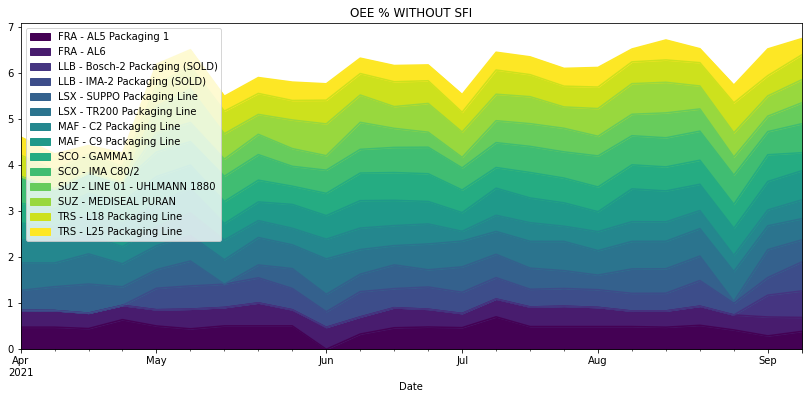

In [271]:
# for filtering in regex
SFI='M18|M21|M22'
WITHOUT_SFI='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL'

df_weekly.pivot(index='Date',columns='Line',values='OEE %').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('OEE % WITHOUT SFI')

Text(0.5, 1.0, 'WITHOUT SFI Changeover OEE losses stacked')

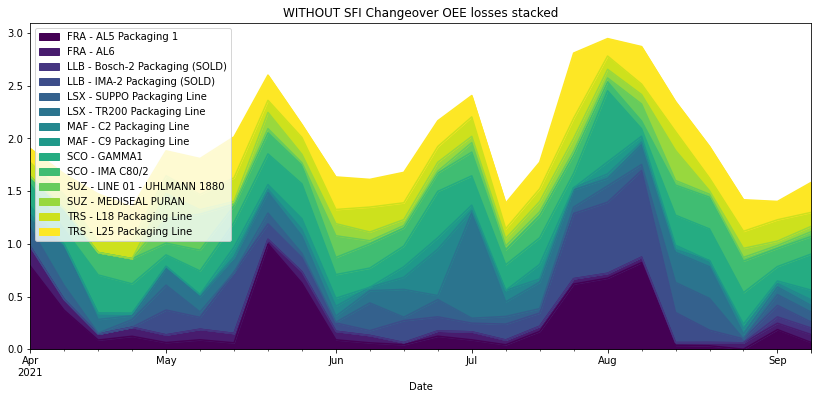

In [272]:
df_weekly.pivot(index='Date',columns='Line',values='Changeover').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('WITHOUT SFI Changeover OEE losses stacked')

Text(0.5, 1.0, 'Unplanned Technical Outage OEE losses stacked SFI')

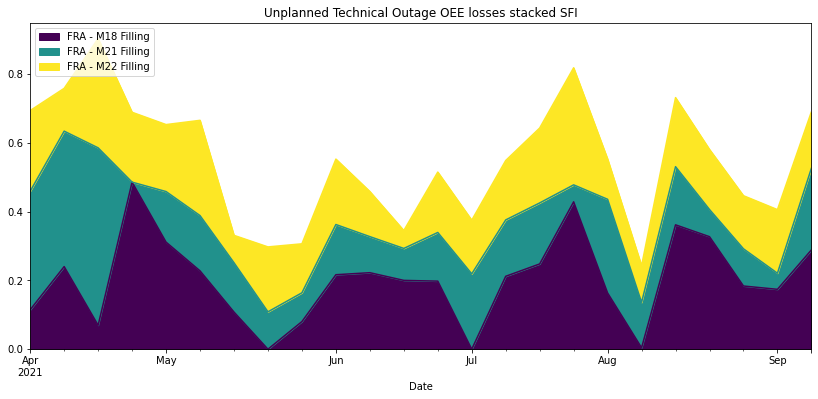

In [273]:
df_weekly.pivot(index='Date', columns='Line', values='Unplanned_tech_loss').filter(regex=SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('Unplanned Technical Outage OEE losses stacked SFI')

In [274]:
df_weekly[['Line','OEE %','OEE_Diff', 'rolling_std','Unplanned_tech_loss','Changeover_rolling_mean','Review_Date','Date']][df_weekly.Line.str.contains('LLB - IMA')]

,Line,OEE %,OEE_Diff,rolling_std,Unplanned_tech_loss,Changeover_rolling_mean,Review_Date,Date
332,LLB - IMA-2 Packaging (SOLD),0.466862,0.000000,NaN,0.514876,NaN,2021-05-13,2021-05-02
333,LLB - IMA-2 Packaging (SOLD),0.504700,0.037838,0.026755,0.266246,0.112390,2021-05-13,2021-05-09
334,LLB - IMA-2 Packaging (SOLD),0.504700,0.000000,0.021846,0.479049,0.112390,2021-06-10,2021-05-16
335,LLB - IMA-2 Packaging (SOLD),0.545460,0.040760,0.032099,0.229780,0.129484,2021-06-10,2021-05-23
336,LLB - IMA-2 Packaging (SOLD),0.463008,-0.082453,0.033662,0.324034,0.130285,2021-06-10,2021-05-30
337,LLB - IMA-2 Packaging (SOLD),0.338598,-0.124410,0.089470,0.418165,0.119079,2021-06-10,2021-06-06
338,LLB - IMA-2 Packaging (SOLD),0.550189,0.211591,0.098937,0.268748,0.100766,2021-07-08,2021-06-13
339,LLB - IMA-2 Packaging (SOLD),0.415483,-0.134707,0.088584,0.248293,0.116320,2021-07-08,2021-06-20
340,LLB - IMA-2 Packaging (SOLD),0.482505,0.067022,0.090650,0.328428,0.116798,2021-07-08,2021-06-27
341,LLB - IMA-2 Packaging (SOLD),0.460212,-0.022293,0.056134,0.418439,0.117701,2021-07-08,2021-07-04


In [275]:
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)
# highlighted_sectors['sector_1'] = highlighted_sectors['sector_1'].mul(-1)
# highlighted_sectors['sector_3'] = highlighted_sectors['sector_3'].mul(-1)
# highlighted_sectors = df_weekly.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index().style.highlight_max(color = 'purple', axis = 0)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: purple' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: purple' if v else '' for v in is_min]


highlighted_sectors = df_weekly[df_weekly.Review_Date == '2021-09-16']
highlighted_sectors = highlighted_sectors.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index()
# highlighted_sectors.filter(regex='Line|_1').style.highlight_min(color = 'purple', axis=0)
# highlighted_sectors.style.highlight_min(subset=['sector_1'], color='purple')\
#     .highlight_max(subset=['sector_2'], color='purple')\
#     .highlight_min(subset=['sector_3'], color='purple')\
#     .highlight_max(subset=['sector_4'], color='purple')\
highlighted_sectors.style.background_gradient(subset=['sector_1'], cmap='Purples_r')\
    .background_gradient(subset=['sector_2'], cmap='Greens_r')\
    .background_gradient(subset=['sector_3'], cmap='Blues_r')\
    .background_gradient(subset=['sector_4'], cmap='Oranges_r')
# highlighted_sectors['sector_1'] = df_weekly.pivot(index='Line', columns='Date', values='sector_1').style.highlight_max(color = 'purple', axis = 0)
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)


In [276]:
all_sectors_pivot = all_sectors.pivot(index='Line', columns='Review_Date', values=['lap_time','sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11'])
all_sectors_pivot.style.background_gradient(cmap='Purples_r')

adding a weekly race_time just for the gapminder presentation

In [277]:
weekly_race_time = df_weekly.groupby(['Line','Date'])['lap_time'].sum().groupby('Line').cumsum().reset_index()
weekly_race_time.rename(columns={'lap_time' : 'race_time'}, inplace=True)
weekly_race_time['race_time'] = weekly_race_time['race_time'] + 88
df_weekly = df_weekly.merge(weekly_race_time[['Line','Date','race_time']], on=(['Line','Date']))
# df_weekly.drop(columns={'race_time'}, inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),McL_Start_OEE,Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,lap_time,Plant Line,Process,race_time
0,W13-2021,FRA - M18 Filling,0.046124,13,2021,2021-04-04,Frankfurt,0.443522,0.650,0.454063,0.114818,0.789781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.397398,0.000000,0.789781,0.397398,0.092453,0.114818,0.789781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.394450,FRA FRA,FILLING,89.394450
1,W14-2021,FRA - M18 Filling,0.463021,14,2021,2021-04-11,Frankfurt,0.443522,0.650,0.454063,0.240339,0.095404,0.294791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.416897,-0.694377,0.442593,-0.416897,0.294791,0.240339,0.442593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.560825,FRA FRA,FILLING,89.955275
2,W15-2021,FRA - M18 Filling,0.386723,15,2021,2021-04-18,Frankfurt,0.443522,0.650,0.454063,0.069673,0.390417,0.221973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13,-0.076297,0.295012,0.425201,0.076297,0.221973,0.069673,0.425201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.793144,FRA FRA,FILLING,90.748419
3,W16-2021,FRA - M18 Filling,0.352420,16,2021,2021-04-25,Frankfurt,0.443522,0.650,0.454063,0.485988,0.033241,0.183226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13,-0.034303,-0.357176,0.327211,0.034303,0.183226,0.485988,0.327211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.030727,FRA FRA,FILLING,91.779147
4,W17-2021,FRA - M18 Filling,0.530336,17,2021,2021-05-02,Frankfurt,0.443522,0.650,0.454063,0.311511,0.029190,0.079604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13,0.177917,-0.004051,0.137063,-0.177917,0.079604,0.311511,0.137063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.350261,FRA FRA,FILLING,92.129408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,W34-2021,SUZ - MEDISEAL PURAN,0.526363,34,2021,2021-08-29,SUZANO,0.577761,0.607,NaN,0.227340,0.085377,0.089006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16,0.027835,0.052082,0.069384,-0.027835,0.089006,0.227340,0.069384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.357895,SUZ SUZ,PACKAGING,95.964944
370,W35-2021,SUZ - MEDISEAL PURAN,0.440256,35,2021,2021-09-05,SUZANO,0.577761,0.607,NaN,0.282517,0.041603,0.095479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16,-0.086107,-0.043774,0.053425,0.086107,0.095479,0.282517,0.053425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.517529,SUZ SUZ,PACKAGING,96.482473
371,W36-2021,SUZ - MEDISEAL PURAN,0.501974,36,2021,2021-09-12,SUZANO,0.577761,0.607,NaN,0.230374,0.050642,0.036516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,2021-09-16,0.061718,0.009039,0.052729,-0.061718,0.036516,0.230374,0.052729,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-3.85,-3.592099,SUZ SUZ,PACKAGING,92.890374
372,W35-2021,LLB - Bosch-2 Packaging (SOLD),0.474879,35,2021,2021-09-05,Luleburgaz,0.585000,0.560,NaN,0.192086,0.060430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16,-0.110121,0.000000,0.060430,0.110121,0.092453,0.192086,0.060430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.455090,LUL LLB,PACKAGING,88.455090


In [278]:
# create output for gapminder.  weekly race_time is useful for plotting and change Date format to yyyymmdd so that gapminder handles it.
df_weekly['Date'] = df_weekly['Date'].dt.strftime('%Y%m%d')
gapminder_weekly = df_weekly[['Line','Date','sector_1','sector_2','sector_3','sector_4','lap_time','race_time']]
filename = 'gapminder_weekly.csv'
gapminder_weekly.to_csv(os.path.join(dir_local, folder, filename), index=False)

In [279]:
temp_df = df_weekly.pivot_table(index='Date', columns='Line', values='OEE %')
temp_df.columns

Index(['FRA - AL5 Packaging 1', 'FRA - AL6', 'FRA - M18 Filling',
       'FRA - M21 Filling', 'FRA - M22 Filling',
       'LLB - Bosch-2 Packaging (SOLD)', 'LLB - IMA-2 Packaging (SOLD)',
       'LSX - SUPPO Packaging Line', 'LSX - TR200 Packaging Line',
       'MAF - C2 Packaging Line', 'MAF - C9 Packaging Line', 'SCO - GAMMA1',
       'SCO - IMA C80/2', 'SUZ - LINE 01 - UHLMANN 1880',
       'SUZ - MEDISEAL PURAN', 'TRS - L18 Packaging Line',
       'TRS - L25 Packaging Line'],
      dtype='object', name='Line')

<AxesSubplot:title={'center':'OEE% SFI'}, xlabel='Date'>

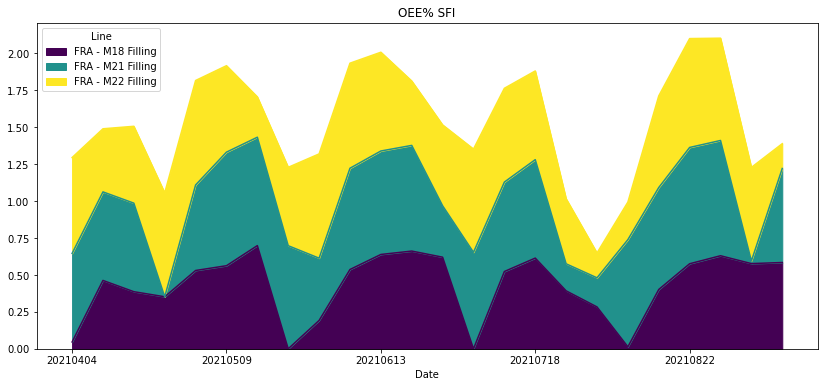

In [280]:
df_weekly.pivot_table(index='Date', columns='Line', values='OEE %').filter(regex='M18|M21|M22').plot.area(figsize=(14,6), title='OEE% SFI', cmap='viridis')
# plt(color='')
# temp_df.pivot_table(index='Date', columns='Line', values='OEE %').plot.area(figsize=(24,10), linestyle='--') 
# plt.title('SFI OEE values%') 
# plt.xlabel('Changeover')
# plt.ylabel('OEE% % Lost')

<AxesSubplot:title={'center':'Changeover Without SFI'}, xlabel='Date'>

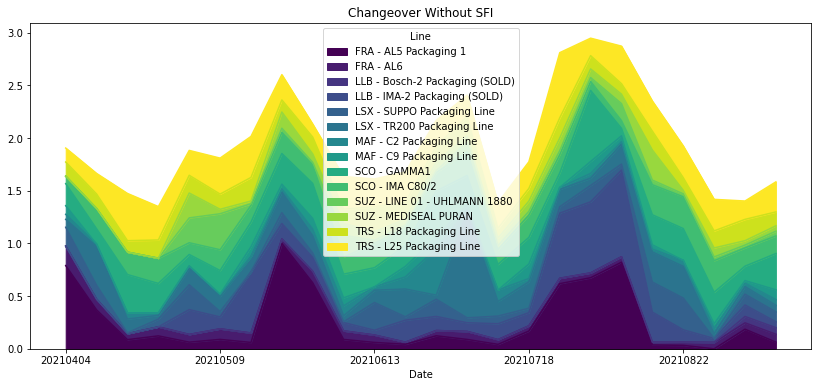

In [281]:
df_weekly.pivot_table(index='Date', columns='Line', values='Changeover').filter(regex='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL').plot.area(figsize=(14,6), title='Changeover Without SFI', cmap='viridis')


In [282]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Week                          374 non-null    object        
 1   Line                          374 non-null    object        
 2   OEE %                         374 non-null    float64       
 3   WeekOfYear                    374 non-null    int64         
 4   Year                          374 non-null    int64         
 5   Date                          374 non-null    object        
 6   Plant                         374 non-null    object        
 7   OEE  Start point              374 non-null    float64       
 8   OEE% Target (2022)            374 non-null    float64       
 9   McL_Start_OEE                 264 non-null    float64       
 10  Unplanned_tech_loss           374 non-null    float64       
 11  Changeover                    37

In [283]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Line                 17 non-null     object 
 1   2021-04-15 00:00:00  17 non-null     float64
 2   2021-05-13 00:00:00  17 non-null     float64
 3   2021-06-10 00:00:00  17 non-null     float64
 4   2021-07-08 00:00:00  17 non-null     float64
 5   2021-08-19 00:00:00  17 non-null     float64
 6   2021-09-16 00:00:00  17 non-null     float64
 7   race_time            17 non-null     float64
 8   prev_race_time       17 non-null     float64
 9   Plant                17 non-null     object 
 10  position             17 non-null     int32  
 11  gap_to_leader        17 non-null     float64
 12  prev_position        17 non-null     int32  
 13  Gain/Loss            17 non-null     int32  
 14  interval             16 non-null     float64
 15  OEE  Start point     17 non-null     objec

In [284]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Week                          374 non-null    object        
 1   Line                          374 non-null    object        
 2   OEE %                         374 non-null    float64       
 3   WeekOfYear                    374 non-null    int64         
 4   Year                          374 non-null    int64         
 5   Date                          374 non-null    object        
 6   Plant                         374 non-null    object        
 7   OEE  Start point              374 non-null    float64       
 8   OEE% Target (2022)            374 non-null    float64       
 9   McL_Start_OEE                 264 non-null    float64       
 10  Unplanned_tech_loss           374 non-null    float64       
 11  Changeover                    37